In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random
from dataloader import UTKFaceDataset
import seaborn as sns
import pandas as pd
from ae import AutoEncoderNet
from torchvision.utils import make_grid
from sklearn import metrics
from sklearn.cluster import KMeans
from matplotlib import gridspec
from sklearn import metrics


## Dataset and dataloader

In [3]:
BATCH_SIZE = 64
DEVICE = "cpu"

dataset = UTKFaceDataset(data_type="test", gray_scale=False)
test_loader = torch.utils.data.DataLoader(dataset,batch_size= BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

## Load pretrained model

In [4]:
model_path = "models/AutoEncoder_256.pt"
model = AutoEncoderNet(n_channels=3, dim_last_layer=(64, 21, 21), latent_features=256)
model.load_state_dict(torch.load(model_path))
model.to(DEVICE)
model.eval()

AutoEncoderNet(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Linear(in_features=28224, out_features=512, bias=True)
    (13): ReLU()
    (14): Linear(in_features=512, out_features=256, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=28224, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(64, 21, 21))
    (3): ConvTranspose2d(64, 64, kerne

## Reconstruction of test batch

<Figure size 432x288 with 0 Axes>

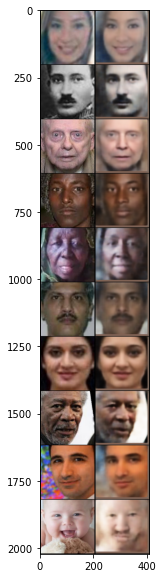

In [5]:

batch = next(iter(test_loader))

plt.figure()
imgs, labels = batch
imgs = imgs[:10]
grid1 = np.asarray(make_grid(imgs,nrow=1).permute(1, 2, 0))
_, rec = model(imgs.to(DEVICE))

grid2 = np.asarray(make_grid(rec.cpu(),nrow=1).permute(1, 2, 0))

plt.figure(figsize=(10,10))
plt.imshow(np.concatenate((grid1,grid2),axis=1))


## Save latent space of test set

In [6]:
zs = []
ys = []
for i, (x, y) in enumerate(test_loader):
    mu = model.encoder(x.to(DEVICE))
    zs.append(mu.detach().cpu())
    ys.append(y.cpu())

z = torch.concat(zs)
y = torch.concat(ys)

np.save("Z.npy", z.numpy())
np.save("Y.npy", y.numpy())


## K-Means Clustering

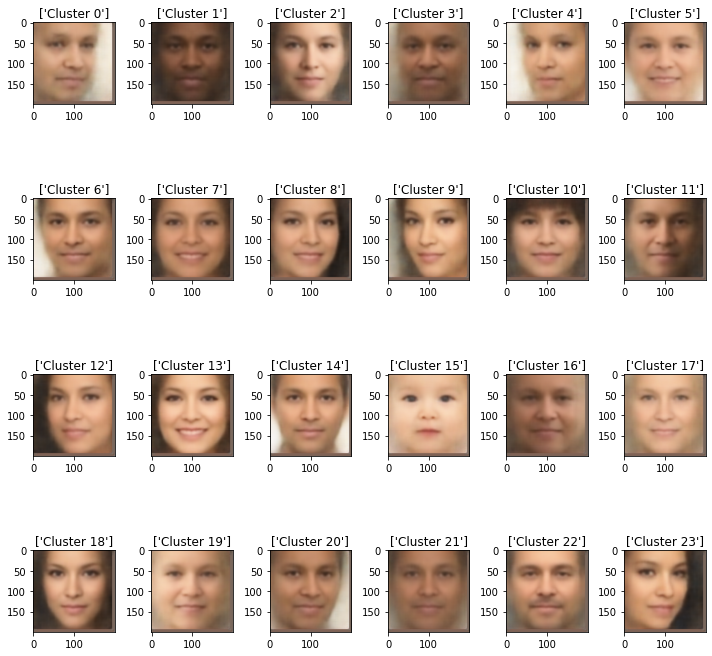

In [7]:
## 8 Clusters
kmeans = KMeans(n_clusters=24,random_state=42)
labels = kmeans.fit_predict(z)

## Visualize cluster centers
C = kmeans.cluster_centers_ # the cluster means
resp = kmeans.labels_ # a vector of the cluster number for each observation

gs = gridspec.GridSpec(4, 6)
fig = plt.figure(figsize=(10,10))
for i in range(len(C)):
    ax = fig.add_subplot(gs[i])
    latent = torch.from_numpy(C[i]).unsqueeze(0).to(DEVICE).float()
    c = model.decoder(latent).detach().cpu().squeeze().permute(1, 2, 0).numpy()
    ax.imshow(c)
    ax.set_title(['Cluster %d' %i])
    ax.set_aspect('equal', adjustable='box')

fig.tight_layout()
plt.show()


/homes/hinge/venv/MRI-to-PET/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


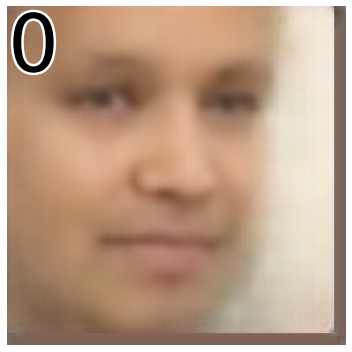

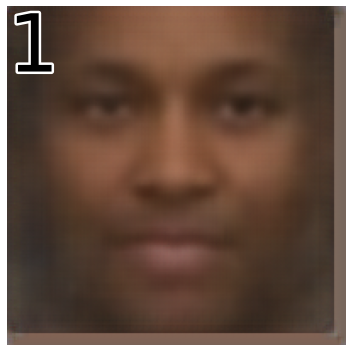

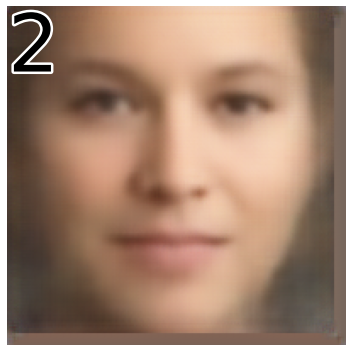

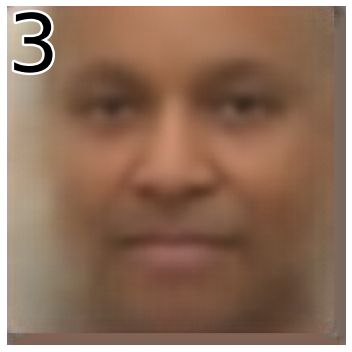

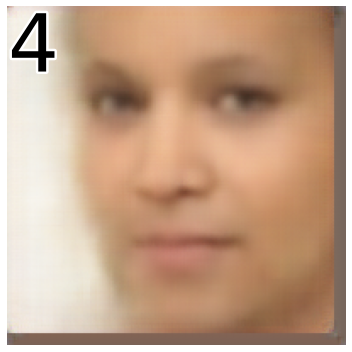

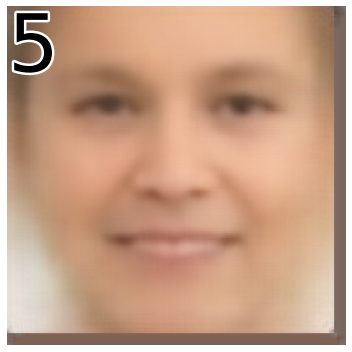

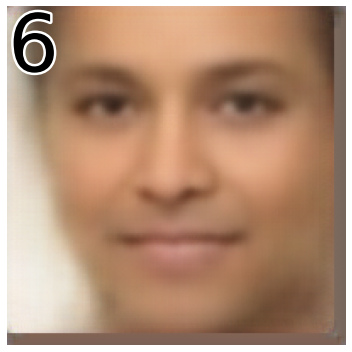

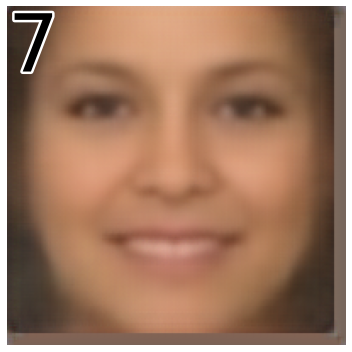

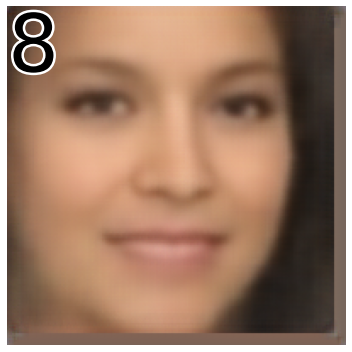

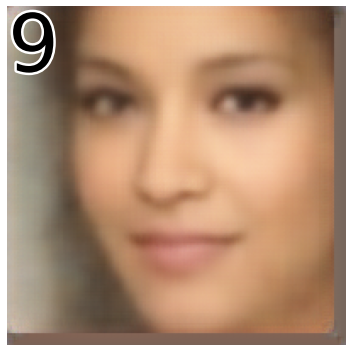

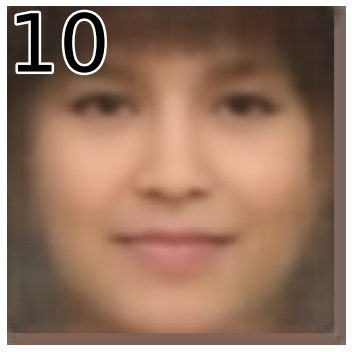

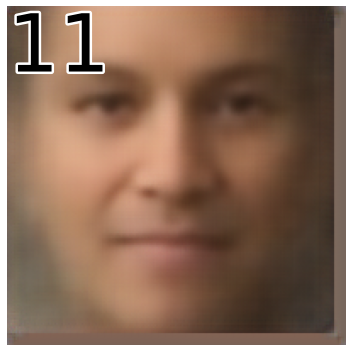

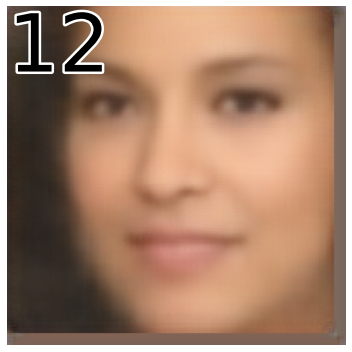

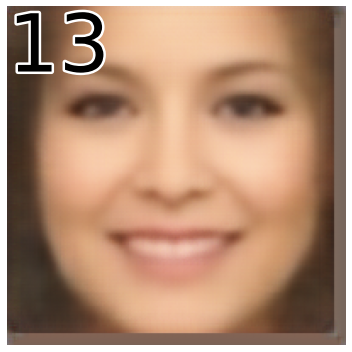

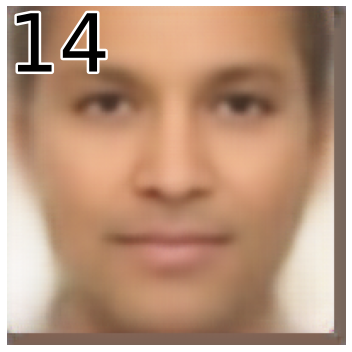

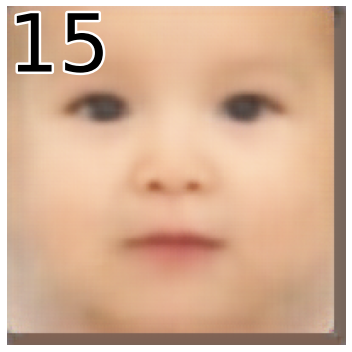

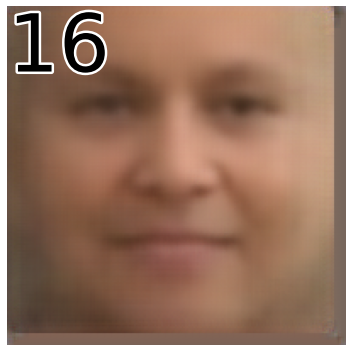

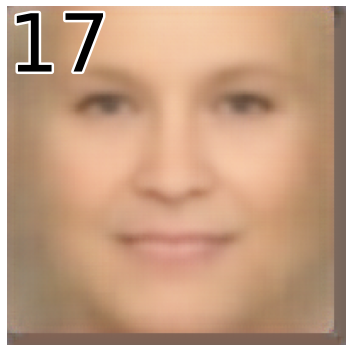

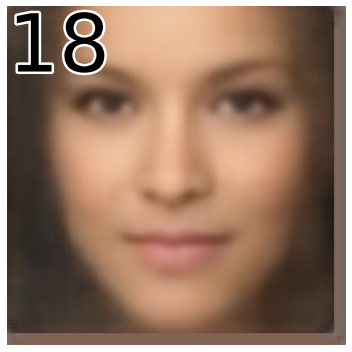

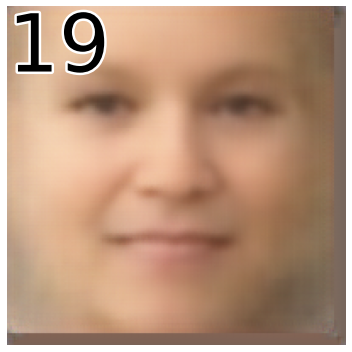

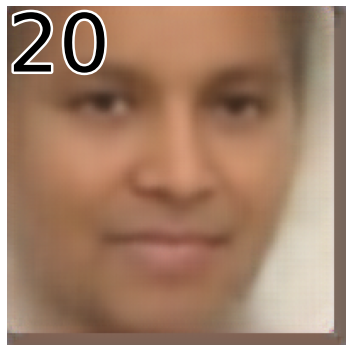

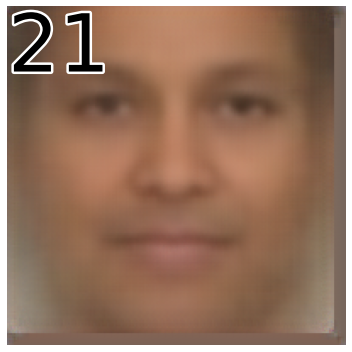

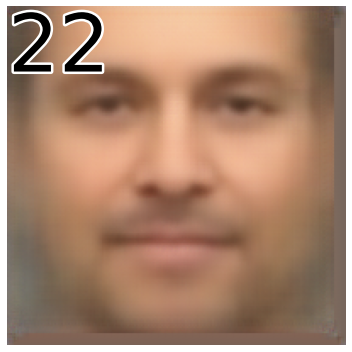

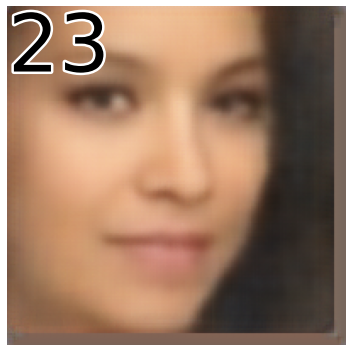

In [21]:
import matplotlib.patheffects as PathEffects

for i in range(len(C)):
    latent = torch.from_numpy(C[i]).unsqueeze(0).to(DEVICE).float()
    c = model.decoder(latent).detach().cpu().squeeze().permute(1, 2, 0).numpy()
    plt.figure(figsize=(5,5))
    plt.imshow(c)
    plt.axis('off')
    plt.tight_layout()
    txt = plt.text(0, 38, str(i), fontsize = 80)
    txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
    plt.savefig(f"centers/center_{i}.png")


Fortolking af clusters:
- Cluster 0 fanger mænd som vender med højre kind mod kamera (lys baggrund)
- Cluster 4 fanger mennesker som vender med højre kind mod kamera  (mørk baggrund)
- Cluster 7 fanger mennesker som vender med venstre kind mod kamera  (lys baggrund)
- Cluster 6 fanger mennesker som vender med venstre kind mod kamera  (mørk baggrund)
- Cluster 3 fanger mørkere hudfarver.
- Cluster 5 fanger børn/babyer
- Cluster 1 fanger kvinder
- Cluster 2 fanger mænd

/homes/hinge/venv/MRI-to-PET/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


center    purity
0        0  0.659091
1        1  0.578125
2        2  0.543624
3        3  0.757202
4        4  0.494845
5        5  0.613333
6        6  0.601449
7        7  0.271127
8        8  0.294355
9        9  0.257143
10      10  0.350365
11      11  0.665049
12      12  0.327103
13      13  0.045198
14      14  0.788991
15      15  0.538860
16      16  0.609053
17      17  0.462585
18      18  0.250000
19      19  0.560185
20      20  0.684564
21      21  0.718421
22      22  0.941909
23      23  0.277778

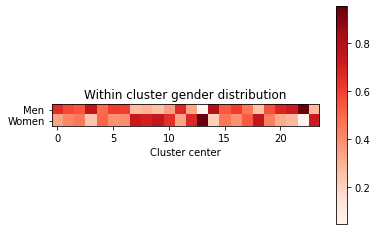

In [24]:
m = metrics.cluster.contingency_matrix(y[:,1], labels)
purity = m/m.sum(axis=0,keepdims=True)
plt.imshow(purity,cmap="Reds")
plt.colorbar()
plt.xlabel("Cluster center")
plt.gca().set_yticklabels(["","Men","Women"])
plt.title("Within cluster gender distribution")


df = pd.DataFrame({"center": np.arange(24),"purity": purity[0,:]})
df

In [27]:
df.sort_values("purity")

center    purity
13      13  0.045198
18      18  0.250000
9        9  0.257143
7        7  0.271127
23      23  0.277778
8        8  0.294355
12      12  0.327103
10      10  0.350365
17      17  0.462585
4        4  0.494845
15      15  0.538860
2        2  0.543624
19      19  0.560185
1        1  0.578125
6        6  0.601449
16      16  0.609053
5        5  0.613333
0        0  0.659091
11      11  0.665049
20      20  0.684564
21      21  0.718421
3        3  0.757202
14      14  0.788991
22      22  0.941909

/homes/hinge/venv/MRI-to-PET/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


Text(0.5, 1.0, 'Within cluster race distribution')

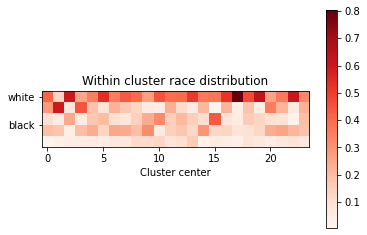

In [32]:
m = metrics.cluster.contingency_matrix(y[:,2], labels)
purity = m/m.sum(axis=0,keepdims=True)
plt.imshow(purity,cmap="Reds")
plt.colorbar()
plt.xlabel("Cluster center")
plt.gca().set_yticklabels(["","white", "black", "asian", "indian", "others"])
plt.title("Within cluster race distribution")

In [34]:
df = pd.DataFrame({"center": np.arange(24),"white":purity[0,:], "black":purity[1,:], "asian":purity[2,:], "indian":purity[3,:], "others":purity[4,:]})
df.sort_values("white",ascending=False)

center     white     black     asian    indian    others
17      17  0.802721  0.037415  0.047619  0.085034  0.027211
19      19  0.629630  0.041667  0.134259  0.125000  0.069444
22      22  0.605809  0.062241  0.024896  0.215768  0.091286
2        2  0.597315  0.080537  0.248322  0.033557  0.040268
5        5  0.540000  0.086667  0.200000  0.133333  0.040000
16      16  0.522634  0.218107  0.078189  0.135802  0.045267
13      13  0.508475  0.056497  0.152542  0.124294  0.158192
18      18  0.472222  0.185185  0.162037  0.092593  0.087963
10      10  0.452555  0.043796  0.321168  0.051095  0.131387
7        7  0.440141  0.169014  0.073944  0.246479  0.070423
0        0  0.409091  0.284091  0.102273  0.193182  0.011364
8        8  0.403226  0.133065  0.149194  0.193548  0.120968
12      12  0.401869  0.116822  0.205607  0.172897  0.102804
11      11  0.393204  0.233010  0.145631  0.145631  0.082524
15      15  0.373057  0.005181  0.440415  0.129534  0.051813
14      14  0.366972  0.211009  0.110092  0.293578  0.018349
21      21  0.360526  0.218421  0.092105  0.257895  0.071053
6        6  0.355072  0.224638  0.101449  0.253623  0.065217
4        4  0.350515  0.185567  0.175258  0.237113  0.051546
23      23  0.326389  0.229167  0.194444  0.180556  0.069444
9        9  0.276190  0.057143  0.238095  0.314286  0.114286
20      20  0.261745  0.355705  0.100671  0.241611  0.040268
3        3  0.255144  0.452675  0.053498  0.193416  0.045267
1        1  0.137500  0.600000  0.050000  0.178125  0.034375

In [35]:
df.sort_values("black",ascending=False)

center     white     black     asian    indian    others
1        1  0.137500  0.600000  0.050000  0.178125  0.034375
3        3  0.255144  0.452675  0.053498  0.193416  0.045267
20      20  0.261745  0.355705  0.100671  0.241611  0.040268
0        0  0.409091  0.284091  0.102273  0.193182  0.011364
11      11  0.393204  0.233010  0.145631  0.145631  0.082524
23      23  0.326389  0.229167  0.194444  0.180556  0.069444
6        6  0.355072  0.224638  0.101449  0.253623  0.065217
21      21  0.360526  0.218421  0.092105  0.257895  0.071053
16      16  0.522634  0.218107  0.078189  0.135802  0.045267
14      14  0.366972  0.211009  0.110092  0.293578  0.018349
4        4  0.350515  0.185567  0.175258  0.237113  0.051546
18      18  0.472222  0.185185  0.162037  0.092593  0.087963
7        7  0.440141  0.169014  0.073944  0.246479  0.070423
8        8  0.403226  0.133065  0.149194  0.193548  0.120968
12      12  0.401869  0.116822  0.205607  0.172897  0.102804
5        5  0.540000  0.086667  0.200000  0.133333  0.040000
2        2  0.597315  0.080537  0.248322  0.033557  0.040268
22      22  0.605809  0.062241  0.024896  0.215768  0.091286
9        9  0.276190  0.057143  0.238095  0.314286  0.114286
13      13  0.508475  0.056497  0.152542  0.124294  0.158192
10      10  0.452555  0.043796  0.321168  0.051095  0.131387
19      19  0.629630  0.041667  0.134259  0.125000  0.069444
17      17  0.802721  0.037415  0.047619  0.085034  0.027211
15      15  0.373057  0.005181  0.440415  0.129534  0.051813

In [36]:
df.sort_values("asian",ascending=False)

center     white     black     asian    indian    others
15      15  0.373057  0.005181  0.440415  0.129534  0.051813
10      10  0.452555  0.043796  0.321168  0.051095  0.131387
2        2  0.597315  0.080537  0.248322  0.033557  0.040268
9        9  0.276190  0.057143  0.238095  0.314286  0.114286
12      12  0.401869  0.116822  0.205607  0.172897  0.102804
5        5  0.540000  0.086667  0.200000  0.133333  0.040000
23      23  0.326389  0.229167  0.194444  0.180556  0.069444
4        4  0.350515  0.185567  0.175258  0.237113  0.051546
18      18  0.472222  0.185185  0.162037  0.092593  0.087963
13      13  0.508475  0.056497  0.152542  0.124294  0.158192
8        8  0.403226  0.133065  0.149194  0.193548  0.120968
11      11  0.393204  0.233010  0.145631  0.145631  0.082524
19      19  0.629630  0.041667  0.134259  0.125000  0.069444
14      14  0.366972  0.211009  0.110092  0.293578  0.018349
0        0  0.409091  0.284091  0.102273  0.193182  0.011364
6        6  0.355072  0.224638  0.101449  0.253623  0.065217
20      20  0.261745  0.355705  0.100671  0.241611  0.040268
21      21  0.360526  0.218421  0.092105  0.257895  0.071053
16      16  0.522634  0.218107  0.078189  0.135802  0.045267
7        7  0.440141  0.169014  0.073944  0.246479  0.070423
3        3  0.255144  0.452675  0.053498  0.193416  0.045267
1        1  0.137500  0.600000  0.050000  0.178125  0.034375
17      17  0.802721  0.037415  0.047619  0.085034  0.027211
22      22  0.605809  0.062241  0.024896  0.215768  0.091286

In [37]:
df.sort_values("indian",ascending=False)

center     white     black     asian    indian    others
9        9  0.276190  0.057143  0.238095  0.314286  0.114286
14      14  0.366972  0.211009  0.110092  0.293578  0.018349
21      21  0.360526  0.218421  0.092105  0.257895  0.071053
6        6  0.355072  0.224638  0.101449  0.253623  0.065217
7        7  0.440141  0.169014  0.073944  0.246479  0.070423
20      20  0.261745  0.355705  0.100671  0.241611  0.040268
4        4  0.350515  0.185567  0.175258  0.237113  0.051546
22      22  0.605809  0.062241  0.024896  0.215768  0.091286
8        8  0.403226  0.133065  0.149194  0.193548  0.120968
3        3  0.255144  0.452675  0.053498  0.193416  0.045267
0        0  0.409091  0.284091  0.102273  0.193182  0.011364
23      23  0.326389  0.229167  0.194444  0.180556  0.069444
1        1  0.137500  0.600000  0.050000  0.178125  0.034375
12      12  0.401869  0.116822  0.205607  0.172897  0.102804
11      11  0.393204  0.233010  0.145631  0.145631  0.082524
16      16  0.522634  0.218107  0.078189  0.135802  0.045267
5        5  0.540000  0.086667  0.200000  0.133333  0.040000
15      15  0.373057  0.005181  0.440415  0.129534  0.051813
19      19  0.629630  0.041667  0.134259  0.125000  0.069444
13      13  0.508475  0.056497  0.152542  0.124294  0.158192
18      18  0.472222  0.185185  0.162037  0.092593  0.087963
17      17  0.802721  0.037415  0.047619  0.085034  0.027211
10      10  0.452555  0.043796  0.321168  0.051095  0.131387
2        2  0.597315  0.080537  0.248322  0.033557  0.040268

In [39]:
df.sort_values("others",ascending=False)

center     white     black     asian    indian    others
13      13  0.508475  0.056497  0.152542  0.124294  0.158192
10      10  0.452555  0.043796  0.321168  0.051095  0.131387
8        8  0.403226  0.133065  0.149194  0.193548  0.120968
9        9  0.276190  0.057143  0.238095  0.314286  0.114286
12      12  0.401869  0.116822  0.205607  0.172897  0.102804
22      22  0.605809  0.062241  0.024896  0.215768  0.091286
18      18  0.472222  0.185185  0.162037  0.092593  0.087963
11      11  0.393204  0.233010  0.145631  0.145631  0.082524
21      21  0.360526  0.218421  0.092105  0.257895  0.071053
7        7  0.440141  0.169014  0.073944  0.246479  0.070423
19      19  0.629630  0.041667  0.134259  0.125000  0.069444
23      23  0.326389  0.229167  0.194444  0.180556  0.069444
6        6  0.355072  0.224638  0.101449  0.253623  0.065217
15      15  0.373057  0.005181  0.440415  0.129534  0.051813
4        4  0.350515  0.185567  0.175258  0.237113  0.051546
16      16  0.522634  0.218107  0.078189  0.135802  0.045267
3        3  0.255144  0.452675  0.053498  0.193416  0.045267
20      20  0.261745  0.355705  0.100671  0.241611  0.040268
2        2  0.597315  0.080537  0.248322  0.033557  0.040268
5        5  0.540000  0.086667  0.200000  0.133333  0.040000
1        1  0.137500  0.600000  0.050000  0.178125  0.034375
17      17  0.802721  0.037415  0.047619  0.085034  0.027211
14      14  0.366972  0.211009  0.110092  0.293578  0.018349
0        0  0.409091  0.284091  0.102273  0.193182  0.011364

Text(0.5, 1.0, 'Age distribution for each cluster')

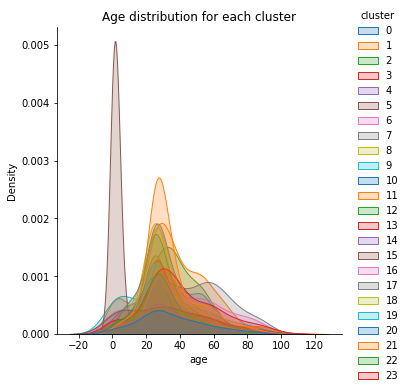

In [40]:
df = pd.DataFrame({"age":y[:,0],"cluster":labels})

sns.displot(df,x="age",hue="cluster",kind="kde", fill=True,palette=sns.color_palette("tab10",24))
plt.title("Age distribution for each cluster")

In [44]:
df.groupby("cluster").median().reset_index()

cluster   age
0         0  29.5
1         1  29.0
2         2  28.0
3         3  35.0
4         4  28.0
5         5  31.0
6         6  29.0
7         7  29.0
8         8  28.0
9         9  25.0
10       10  26.0
11       11  31.5
12       12  27.0
13       13  27.0
14       14  29.0
15       15   1.0
16       16  36.0
17       17  44.0
18       18  26.0
19       19  28.5
20       20  30.0
21       21  34.0
22       22  36.0
23       23  26.0

Her ses det tydeligt at cluster 5 fanger børn

Text(0.5, 1.0, 'Interpolation between two clusters')

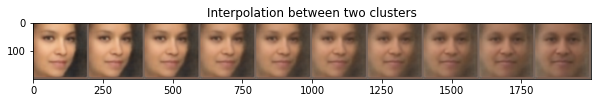

In [15]:
z1 = torch.from_numpy(C[5])
z1 = z1.unsqueeze(0).to(DEVICE)

z2 = torch.from_numpy(C[6])
z2 = z2.unsqueeze(0).to(DEVICE)

alphas = torch.linspace(0,1,steps=10)
model.eval()
plt.figure(figsize=(10,5))

recs = []
for alpha in alphas:
    z_mixed = alpha*z1 + (1-alpha)*z2
    z_mixed = z_mixed.to(DEVICE)
    rec = model.decoder(z_mixed.float())
    rec = rec.squeeze().detach().permute(1, 2, 0).cpu().numpy()
    recs.append(rec)
plt.imshow(np.concatenate(recs,axis=1))
plt.title("Interpolation between two clusters")

## Custom image manipulation

Text(0.5, 1.0, 'Blursed Hinge')

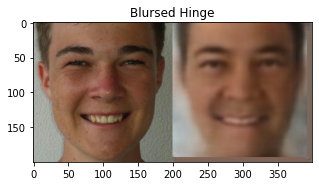

In [29]:
from dataloader import CustomFaceDataset
custom_dataset = CustomFaceDataset()
img = custom_dataset[0]
latent,rec = model(img.unsqueeze(0))
rec = rec.detach().squeeze()

plt.figure(figsize=(5,5))
plt.imshow(np.concatenate((img.permute(1, 2, 0),rec.permute(1, 2, 0)),axis=1))
plt.title("Blursed Hinge")

In [17]:
kmeans.predict(latent.detach().numpy().astype("double"))

array([5], dtype=int32)

Ifølge Kmeans er jeg sort. Må indrømme at jeg havde god tan den sommer

Eksperiment med køn. Jeg interpolerer latent-hinge mod cluster 1, som fanger kvindetræk

Text(0.5, 1.0, 'Feminine Hinge')

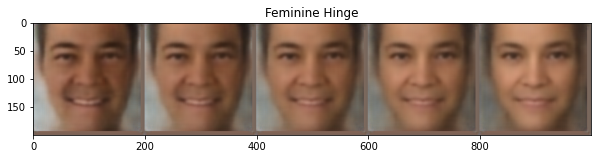

In [31]:
z1 = latent
z2 = torch.from_numpy(C[18])
z2 = z2.unsqueeze(0).to(DEVICE)

alphas = torch.linspace(0,0.5,steps=5)
model.eval()
plt.figure(figsize=(10,5))

recs = []
for alpha in alphas:
    z_mixed = (1-alpha)*z1 + alpha*z2
    z_mixed = z_mixed.to(DEVICE)
    rec = model.decoder(z_mixed.float())
    rec = rec.squeeze().detach().permute(1, 2, 0).cpu().numpy()
    recs.append(rec)
plt.imshow(np.concatenate(recs,axis=1))
plt.title("Feminine Hinge")

## Experiments with GAP statistic
Tyvstjålet fra exercise. Synes ikke det giver noget godt svar lige pt.

In [18]:
X = z.numpy().squeeze()

[N, p] = X.shape

minX = list(np.min(X, axis=0)) # data range min
maxX = list(np.max(X, axis=0)) # data range max

In [19]:
clustersNr = 30
list_of_clusters = range(1,clustersNr + 1,3)
Nsim = 20
Wu = np.zeros((clustersNr, Nsim))
W = np.zeros(clustersNr)
for nrClusters in list_of_clusters: # Want actual number included
    print(nrClusters)
    kmeans = KMeans(n_clusters=nrClusters).fit(X)
    C = kmeans.cluster_centers_ # the cluster centers in the p dimensions
    labelCluster = kmeans.labels_ # the labelling for each point
    
    # Compute within-class dissimilarity given X (the data), C (the cluster centers)
    # and gr (the predicted cluster numbers)
    for cluster in range(1, nrClusters + 1):
        Ik = np.where(labelCluster == cluster - 1)[0]
        dk = np.sum((X[Ik, :] - np.multiply(np.ones((np.size(Ik), 1)), C[cluster - 1, :]))**2, axis = 1)  
        Dk = np.sum(dk)
        W[nrClusters-1] += Dk
    
    
    # gap-statistic
    # Nsim simulations of data uniformly distributed over [X]
    for j in range(Nsim):
        # simulate uniformly distributed data
        Xu = np.ones((N,1))*minX + np.random.rand(N,p)*(np.ones((N,1))*maxX-np.ones((N,1))*minX)
        # perform K-means
        kmeansU = KMeans(n_clusters=nrClusters).fit(Xu)
        Cu = kmeansU.cluster_centers_
        labelClusterU = kmeansU.labels_

        # Compute within-class dissmiliarity for the simulated data given Xu (the simulated data),
        # Cu (the cluster centers for the simulated data), and gru (the predicted cluster numbers)
        # for the simulated data).
        for cluster in range(1, nrClusters+1):
            Iku = np.where(labelClusterU == cluster - 1)
            dku = np.sum((Xu[Iku, :] - np.multiply(np.ones((np.size(Iku), 1)), Cu[cluster - 1, :]))**2, axis = 1)  
            Dku = np.sum(dku)
            Wu[nrClusters - 1, j] += Dku
        
# compute expectation of simulated within-class dissimilarities, and the 
# standard errors for the error bars
Elog_Wu = np.mean(np.log(Wu), axis = 1)
sk = np.std(np.log(Wu), axis=1)*np.sqrt(1+1/Nsim) # standard error sk' in (14.39)
x_range = np.array(range(nrClusters)) + 1

1
4
7
10
13


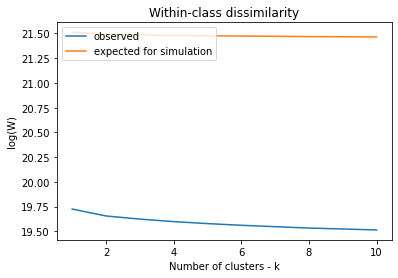

In [26]:
# Plot the log within class scatters
plt.figure()
plt.title("Within-class dissimilarity")
plt.plot(x_range, np.log(W), label='observed')
plt.plot(x_range, Elog_Wu, label='expected for simulation')
plt.legend(loc='upper left')
plt.xlabel("Number of clusters - k")
plt.ylabel("log(W)")
plt.show()

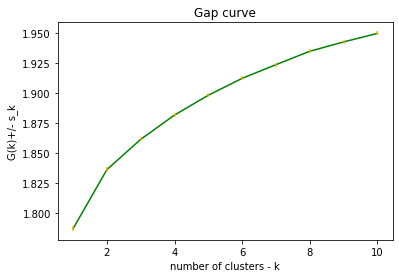

In [27]:
# plot the Gap curve
plt.figure()
plt.title('Gap curve')
Gk =  Elog_Wu.T - np.log(W)
plt.plot(x_range,Gk,color='green')
x_range_list = []
x_range_list.append(x_range)
x_range_list.append(x_range)
GkList = []
GkList.append(Gk-sk)
GkList.append(Gk+sk)
plt.plot(x_range_list, GkList, color='orange')
plt.ylabel('G(k)+/- s_k')
plt.xlabel('number of clusters - k')
plt.show()

In [28]:
# Implementation of the rule for estimating K*, see ESL (14.39), p. 519
K_opt = np.where(np.array(Gk[:-1]) >= np.array(Gk[1:] - sk[1:]))[0]

if not K_opt.size:
    K_opt = clustersNr
    print ("Gap-statistic, optimal K = %d" % K_opt)
else:    
    print ("Gap-statistic, optimal K = %d" % list_of_clusters[K_opt[0]])

Gap-statistic, optimal K = 10


In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
coef = pca.fit(z)

In [23]:
coef.components_.shape

(4, 256)